#### Standard imports

In [17]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.model_selection import train_test_split

from efficientnet_pytorch import EfficientNet

import matplotlib.pyplot as plt

In [2]:
from dotenv import load_dotenv
import os

load_dotenv()

train = os.environ.get("TRAIN_SPECTROGRAM")
test = os.environ.get("TEST_SPECTROGRAM")

#### Defining Image Transforms and Loading datasets

In [3]:
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [18]:
# Load datasets from both directories
dataset = datasets.ImageFolder(train, transform=data_transforms)

In [19]:
# Split combined dataset into training and validation sets
train_indices, val_indices = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)

# Create data samplers
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Create data loaders
train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler, num_workers=4)
val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler, num_workers=4)

#### Loading the models

For VGG-16 model

In [46]:
# Load pre-trained model
model_vgg16 = models.vgg16(pretrained=True)

# Freeze convolutional layers
for param in model_vgg16.parameters():
    param.requires_grad = False

# Modify classifier and have 2 output nodes
num_features = model_vgg16.classifier[6].in_features
model_vgg16.classifier[6] = nn.Linear(num_features, 2)

For VGG-19 model

In [47]:
# Load pre-trained model
model_vgg19 = models.vgg19(pretrained=True)

# Freeze convolutional layers
for param in model_vgg19.parameters():
    param.requires_grad = False

# Modify classifier
num_features_vgg19 = model_vgg19.classifier[6].in_features
model_vgg19.classifier[6] = nn.Linear(num_features_vgg19, 2)

For GoogleNet model

In [48]:
# Load pre-trained GoogLeNet model
model_googlenet = models.googlenet(pretrained=True)

# Freeze convolutional layers
for param in model_googlenet.parameters():
    param.requires_grad = False

# Modify classifier
num_features_googlenet = model_googlenet.fc.in_features
model_googlenet.fc = nn.Linear(num_features_googlenet, 2)

For EfficientNet model

In [49]:
# Load EfficientNet pre-trained model
model_efficientnet = EfficientNet.from_pretrained('efficientnet-b0')

# Freeze convolutional layers
for param in model_efficientnet.parameters():
    param.requires_grad = False

# Modify classifier
num_features_efficientnet = model_efficientnet._fc.in_features
model_efficientnet._fc = nn.Linear(num_features_efficientnet, 2)

Loaded pretrained weights for efficientnet-b0


For ResNet model

In [50]:
# Load pre-trained ResNet model
model_resnet = models.resnet18(pretrained=True)

# Freeze convolutional layers
for param in model_resnet.parameters():
    param.requires_grad = False

# Modify classifier
num_features_resnet = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_features_resnet, 2)

For DenseNet model

In [51]:
# Load pre-trained DenseNet model
model_densenet = models.densenet121(pretrained=True)

# Freeze convolutional layers
for param in model_densenet.parameters():
    param.requires_grad = False

# Modify classifier
num_features_densenet = model_densenet.classifier.in_features
model_densenet.classifier = nn.Linear(num_features_densenet, 2)

In [26]:
# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Training Models

In [59]:
def train_model(model, num_epochs):

    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        corrects_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            corrects_train += torch.sum(preds == labels.data)

        epoch_train_loss = train_loss / len(train_loader.dataset)
        epoch_train_acc = corrects_train.double() / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        corrects_val = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                corrects_val += torch.sum(preds == labels.data)

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = corrects_val.double() / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')

    # Evaluating the model       
    model.eval()
    running_corrects = 0

    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        running_corrects += torch.sum(preds == labels.data)

    accuracy = running_corrects.double() / len(val_loader.sampler)
    print(f'Test Accuracy : {accuracy:.4f}')

    # Plotting loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plotting accuracy curve
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

Epoch 1/60, Train Loss: 0.5165, Train Acc: 0.4819, Val Loss: 0.3584, Val Acc: 0.0783
Epoch 2/60, Train Loss: 0.8466, Train Acc: 0.4819, Val Loss: 0.1909, Val Acc: 0.1265
Epoch 3/60, Train Loss: 0.6707, Train Acc: 0.4940, Val Loss: 0.2158, Val Acc: 0.1145
Epoch 4/60, Train Loss: 0.5521, Train Acc: 0.4759, Val Loss: 0.1620, Val Acc: 0.1145
Epoch 5/60, Train Loss: 0.6980, Train Acc: 0.4337, Val Loss: 0.2059, Val Acc: 0.1084
Epoch 6/60, Train Loss: 0.5495, Train Acc: 0.5060, Val Loss: 0.2322, Val Acc: 0.1145
Epoch 7/60, Train Loss: 0.5609, Train Acc: 0.5120, Val Loss: 0.4190, Val Acc: 0.0783
Epoch 8/60, Train Loss: 1.2375, Train Acc: 0.3976, Val Loss: 0.1740, Val Acc: 0.1024
Epoch 9/60, Train Loss: 0.5933, Train Acc: 0.4639, Val Loss: 0.4611, Val Acc: 0.0783
Epoch 10/60, Train Loss: 0.9530, Train Acc: 0.4880, Val Loss: 0.2958, Val Acc: 0.1265
Epoch 11/60, Train Loss: 1.0044, Train Acc: 0.4880, Val Loss: 0.2329, Val Acc: 0.1265
Epoch 12/60, Train Loss: 0.7536, Train Acc: 0.4880, Val Loss: 0

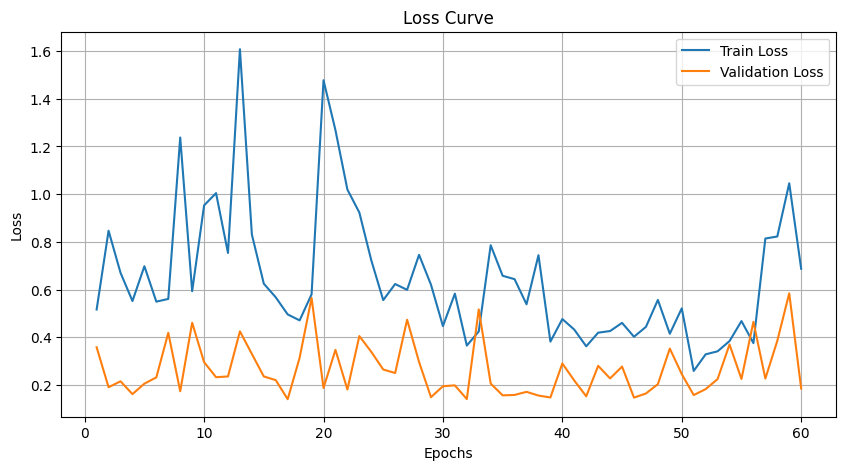

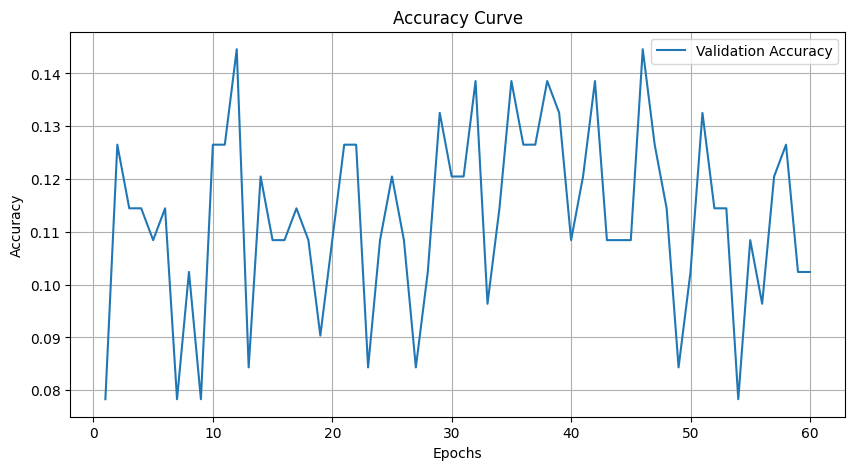

In [61]:
model_vgg16 = train_model(model_vgg16, 60)

Epoch 1/60, Train Loss: 0.7186, Train Acc: 0.3373, Val Loss: 0.1905, Val Acc: 0.0783
Epoch 2/60, Train Loss: 0.6893, Train Acc: 0.4157, Val Loss: 0.1619, Val Acc: 0.0964
Epoch 3/60, Train Loss: 0.5242, Train Acc: 0.4699, Val Loss: 0.1987, Val Acc: 0.0964
Epoch 4/60, Train Loss: 0.5326, Train Acc: 0.5000, Val Loss: 0.1630, Val Acc: 0.1325
Epoch 5/60, Train Loss: 0.4966, Train Acc: 0.5542, Val Loss: 0.2429, Val Acc: 0.1265
Epoch 6/60, Train Loss: 0.9102, Train Acc: 0.4458, Val Loss: 0.1927, Val Acc: 0.1265
Epoch 7/60, Train Loss: 0.7921, Train Acc: 0.4337, Val Loss: 0.2500, Val Acc: 0.0964
Epoch 8/60, Train Loss: 0.7293, Train Acc: 0.4639, Val Loss: 0.4614, Val Acc: 0.0783
Epoch 9/60, Train Loss: 1.0283, Train Acc: 0.4398, Val Loss: 0.2486, Val Acc: 0.1084
Epoch 10/60, Train Loss: 0.7219, Train Acc: 0.5000, Val Loss: 0.2485, Val Acc: 0.1386
Epoch 11/60, Train Loss: 0.6435, Train Acc: 0.5301, Val Loss: 0.1713, Val Acc: 0.1145
Epoch 12/60, Train Loss: 0.5457, Train Acc: 0.5602, Val Loss: 0

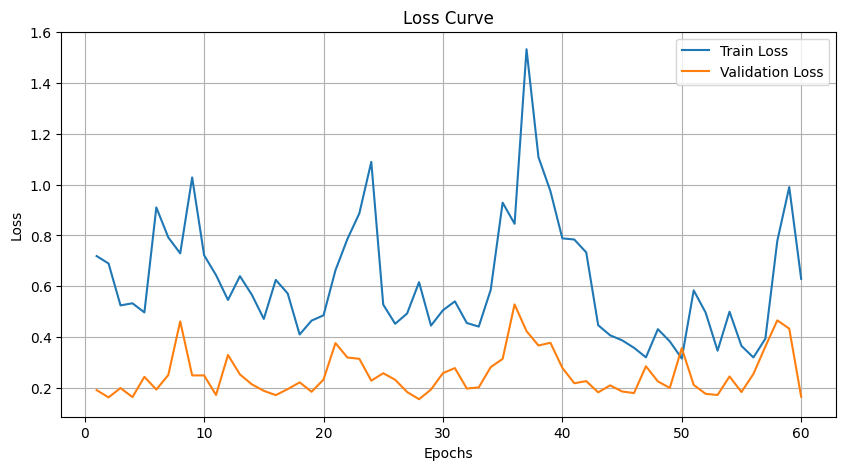

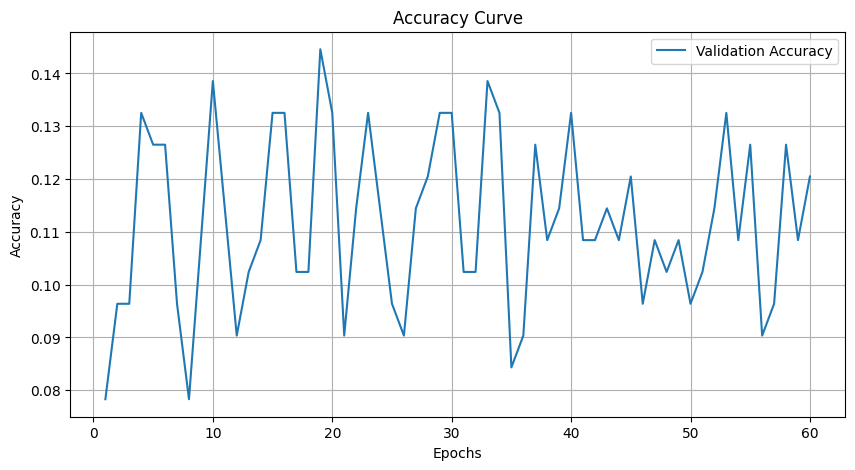

In [62]:
model_vgg19 = train_model(model_vgg19, 60)

Epoch 1/60, Train Loss: 0.6183, Train Acc: 0.3855, Val Loss: 0.1340, Val Acc: 0.1265
Epoch 2/60, Train Loss: 0.5607, Train Acc: 0.4036, Val Loss: 0.1371, Val Acc: 0.1325
Epoch 3/60, Train Loss: 0.5899, Train Acc: 0.4096, Val Loss: 0.2791, Val Acc: 0.0783
Epoch 4/60, Train Loss: 0.7309, Train Acc: 0.4217, Val Loss: 0.1716, Val Acc: 0.1265
Epoch 5/60, Train Loss: 0.5890, Train Acc: 0.4759, Val Loss: 0.2076, Val Acc: 0.0843
Epoch 6/60, Train Loss: 0.5315, Train Acc: 0.5120, Val Loss: 0.1395, Val Acc: 0.1084
Epoch 7/60, Train Loss: 0.5049, Train Acc: 0.5120, Val Loss: 0.1548, Val Acc: 0.0964
Epoch 8/60, Train Loss: 0.4751, Train Acc: 0.5301, Val Loss: 0.1720, Val Acc: 0.0964
Epoch 9/60, Train Loss: 0.5532, Train Acc: 0.4819, Val Loss: 0.1516, Val Acc: 0.1205
Epoch 10/60, Train Loss: 0.5125, Train Acc: 0.4940, Val Loss: 0.1710, Val Acc: 0.0964
Epoch 11/60, Train Loss: 0.4668, Train Acc: 0.5422, Val Loss: 0.1406, Val Acc: 0.1145
Epoch 12/60, Train Loss: 0.4903, Train Acc: 0.5422, Val Loss: 0

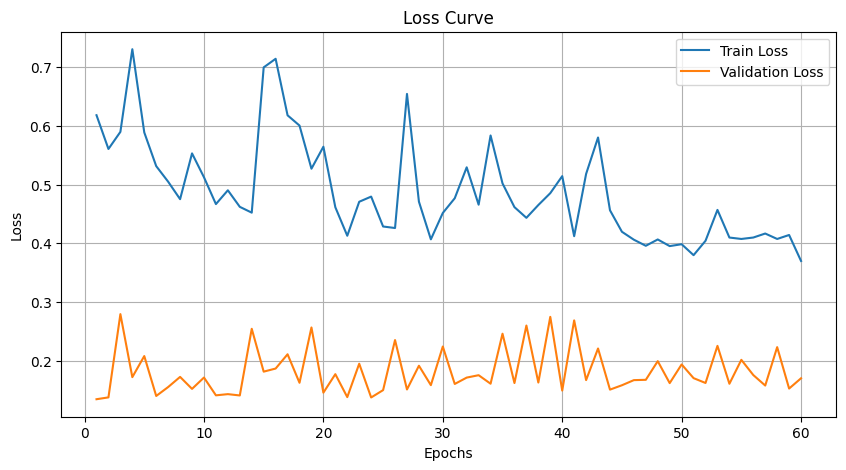

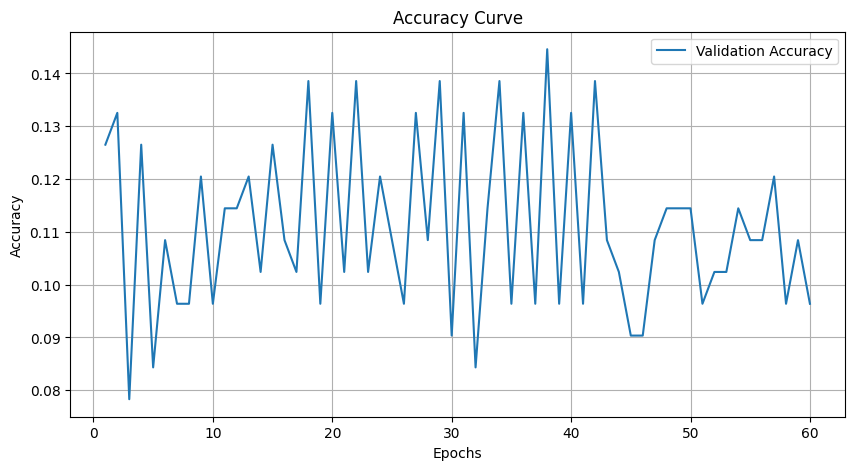

In [63]:
model_googlenet = train_model(model_googlenet, 60)

Epoch 1/60, Train Loss: 0.5452, Train Acc: 0.4639, Val Loss: 0.1443, Val Acc: 0.0964
Epoch 2/60, Train Loss: 0.5677, Train Acc: 0.3133, Val Loss: 0.1537, Val Acc: 0.0783
Epoch 3/60, Train Loss: 0.5525, Train Acc: 0.4096, Val Loss: 0.1385, Val Acc: 0.1265
Epoch 4/60, Train Loss: 0.5411, Train Acc: 0.4337, Val Loss: 0.2265, Val Acc: 0.0783
Epoch 5/60, Train Loss: 0.7716, Train Acc: 0.3795, Val Loss: 0.1454, Val Acc: 0.1265
Epoch 6/60, Train Loss: 0.6094, Train Acc: 0.4337, Val Loss: 0.2078, Val Acc: 0.0783
Epoch 7/60, Train Loss: 0.5722, Train Acc: 0.4699, Val Loss: 0.1485, Val Acc: 0.1084
Epoch 8/60, Train Loss: 0.5495, Train Acc: 0.4940, Val Loss: 0.1392, Val Acc: 0.1145
Epoch 9/60, Train Loss: 0.5815, Train Acc: 0.4578, Val Loss: 0.1893, Val Acc: 0.1084
Epoch 10/60, Train Loss: 0.5340, Train Acc: 0.4639, Val Loss: 0.1417, Val Acc: 0.1205
Epoch 11/60, Train Loss: 0.5038, Train Acc: 0.5060, Val Loss: 0.2693, Val Acc: 0.0843
Epoch 12/60, Train Loss: 0.7037, Train Acc: 0.4699, Val Loss: 0

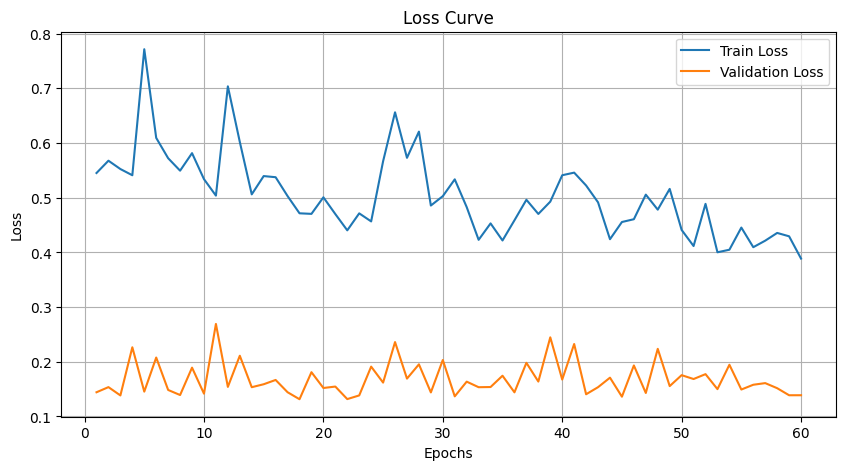

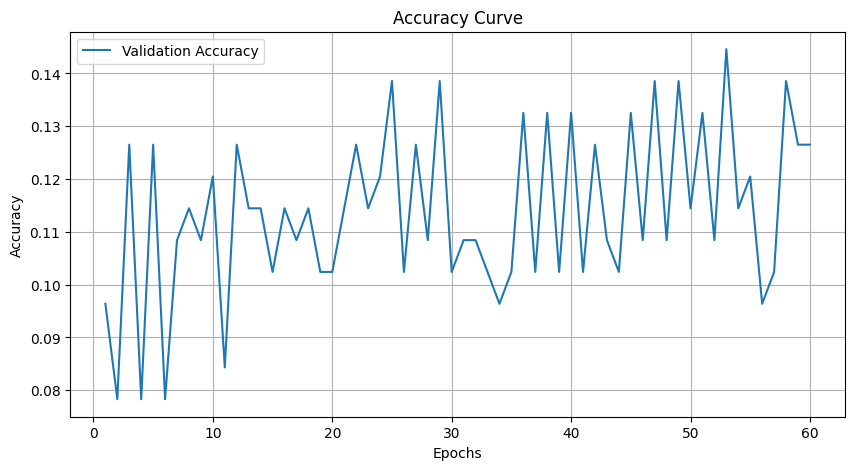

In [64]:
model_efficientnet = train_model(model_efficientnet, 60)

Epoch 1/60, Train Loss: 0.7273, Train Acc: 0.4578, Val Loss: 0.1615, Val Acc: 0.1265
Epoch 2/60, Train Loss: 0.7169, Train Acc: 0.3976, Val Loss: 0.1477, Val Acc: 0.1265
Epoch 3/60, Train Loss: 0.6114, Train Acc: 0.4036, Val Loss: 0.1705, Val Acc: 0.0843
Epoch 4/60, Train Loss: 0.6309, Train Acc: 0.4940, Val Loss: 0.3037, Val Acc: 0.0904
Epoch 5/60, Train Loss: 0.8400, Train Acc: 0.4337, Val Loss: 0.4076, Val Acc: 0.0783
Epoch 6/60, Train Loss: 0.9441, Train Acc: 0.4458, Val Loss: 0.1552, Val Acc: 0.1325
Epoch 7/60, Train Loss: 0.5583, Train Acc: 0.4880, Val Loss: 0.2213, Val Acc: 0.1265
Epoch 8/60, Train Loss: 0.7063, Train Acc: 0.4819, Val Loss: 0.2628, Val Acc: 0.1265
Epoch 9/60, Train Loss: 0.9628, Train Acc: 0.4337, Val Loss: 0.2186, Val Acc: 0.1265
Epoch 10/60, Train Loss: 0.6177, Train Acc: 0.4940, Val Loss: 0.1677, Val Acc: 0.1084
Epoch 11/60, Train Loss: 0.5045, Train Acc: 0.5241, Val Loss: 0.1623, Val Acc: 0.1265
Epoch 12/60, Train Loss: 0.5373, Train Acc: 0.5000, Val Loss: 0

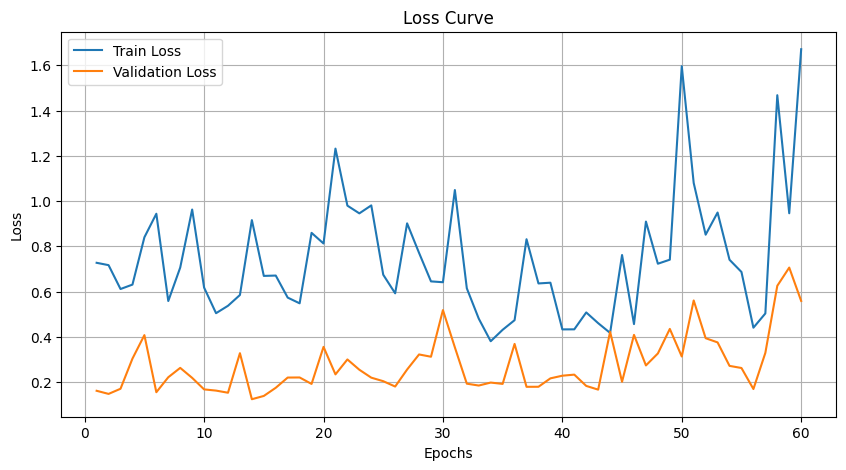

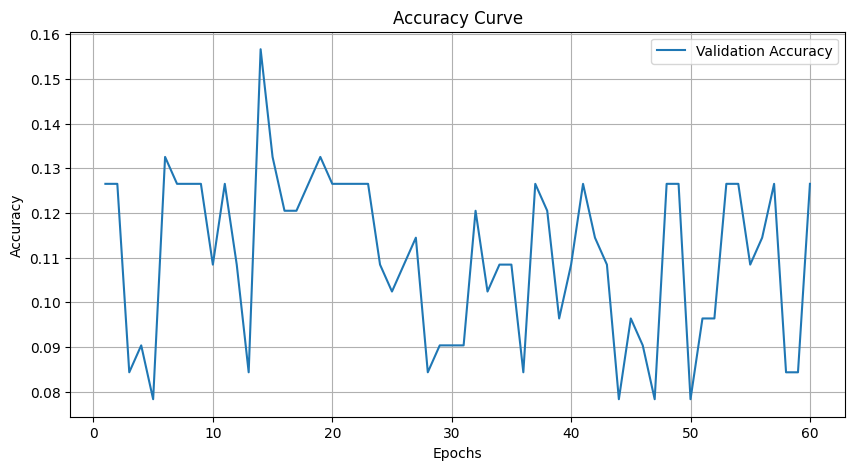

In [65]:
model_resnet = train_model(model_resnet, 60)

Epoch 1/60, Train Loss: 0.6004, Train Acc: 0.3675, Val Loss: 0.1416, Val Acc: 0.0964
Epoch 2/60, Train Loss: 0.6106, Train Acc: 0.4036, Val Loss: 0.1705, Val Acc: 0.0904
Epoch 3/60, Train Loss: 0.5756, Train Acc: 0.4819, Val Loss: 0.2384, Val Acc: 0.0964
Epoch 4/60, Train Loss: 0.5610, Train Acc: 0.5181, Val Loss: 0.1789, Val Acc: 0.1386
Epoch 5/60, Train Loss: 0.7071, Train Acc: 0.4578, Val Loss: 0.4203, Val Acc: 0.1265
Epoch 6/60, Train Loss: 1.6260, Train Acc: 0.3614, Val Loss: 0.2550, Val Acc: 0.0964
Epoch 7/60, Train Loss: 0.6412, Train Acc: 0.5361, Val Loss: 0.2894, Val Acc: 0.0964
Epoch 8/60, Train Loss: 0.5619, Train Acc: 0.5120, Val Loss: 0.2252, Val Acc: 0.1205
Epoch 9/60, Train Loss: 0.5734, Train Acc: 0.5602, Val Loss: 0.2680, Val Acc: 0.1265
Epoch 10/60, Train Loss: 0.7452, Train Acc: 0.5181, Val Loss: 0.1972, Val Acc: 0.1024
Epoch 11/60, Train Loss: 0.4169, Train Acc: 0.5602, Val Loss: 0.2895, Val Acc: 0.0964
Epoch 12/60, Train Loss: 0.5669, Train Acc: 0.5422, Val Loss: 0

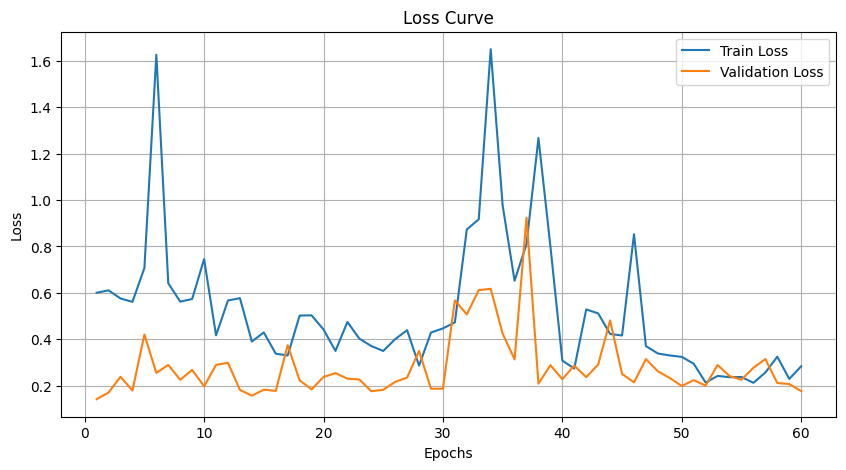

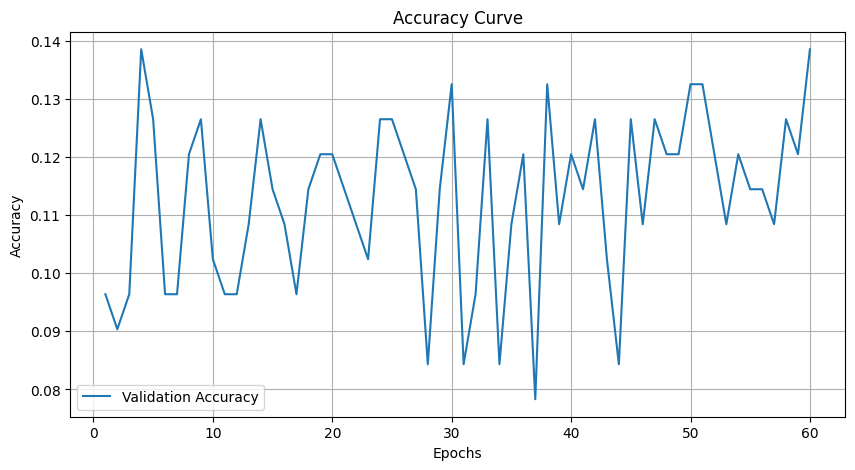

In [66]:
model_densenet = train_model(model_densenet, 60)